# Pitney Bowes Data Challenge_Team 2 
## Noyonika, Balakumaran , Eun Hee

##### Import Data and Check

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

In [5]:
df = pd.read_csv('train_data_cleaned.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40500 entries, 0 to 40499
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         40500 non-null  int64  
 1   deviceid                           40500 non-null  int64  
 2   fail_7                             40500 non-null  int64  
 3   charge_cycle_time_below_12         40500 non-null  int64  
 4   chargecycles                       40500 non-null  float64
 5   dischargecycles                    40500 non-null  float64
 6   total_off_time                     40500 non-null  float64
 7   number_times_restart               40500 non-null  float64
 8   avg_volt_change_charging           40500 non-null  float64
 9   avg_volt_change_discharging        40500 non-null  float64
 10  max_voltage_day                    40500 non-null  float64
 11  piececount                         40500 non-null  flo

##### SMOTE
Use SMOTE technique as the dataset is _highly imbalanced_. <br/>
We have also tried **Boarderline-SMOTE**, but it didn't give us better accuracy than SMOTE oversampling. Therefore we used SMOTE oversampling method to tackle the imbalanced dataset issue.

In [7]:
x = df.drop(['Unnamed: 0','deviceid','fail_7'], axis=1)
y = df['fail_7']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [8]:
# SMOTE: Oversampling
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

x_sm, y_sm = sm.fit_resample(x, y)

print(f'''Shape of X before SMOTE: {x.shape}
Shape of X after SMOTE: {x_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (40500, 15)
Shape of X after SMOTE: (62198, 15)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: fail_7, dtype: float64

In [9]:
# Concatenate and save as a new dataframe
smote_df = pd.concat([x_sm, y_sm], axis=1)
smote_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62198 entries, 0 to 62197
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   charge_cycle_time_below_12         62198 non-null  int64  
 1   chargecycles                       62198 non-null  float64
 2   dischargecycles                    62198 non-null  float64
 3   total_off_time                     62198 non-null  float64
 4   number_times_restart               62198 non-null  float64
 5   avg_volt_change_charging           62198 non-null  float64
 6   avg_volt_change_discharging        62198 non-null  float64
 7   max_voltage_day                    62198 non-null  float64
 8   piececount                         62198 non-null  float64
 9   cycle_time                         62198 non-null  float64
 10  avg_charging_rate_for_all_lags     62198 non-null  float64
 11  avg_discharge_time_for_all_lags    62198 non-null  flo

In [10]:
smote_df.to_csv('SMOTE_train_data.csv')

##### Feature Selection
Use *1) XGBoost and SHAP*, and *2) LightGBM and SHAP* for feature selection. <br/>
We have also tried **LIME** for feature importance, but it allows us to use only one row of a dataset at a time. Therefore, we decided to use SHAP.
<br/>
#### 1) XGBoost and SHAP

In [12]:
x = smote_df.drop(['fail_7'], axis=1)
y = smote_df['fail_7']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

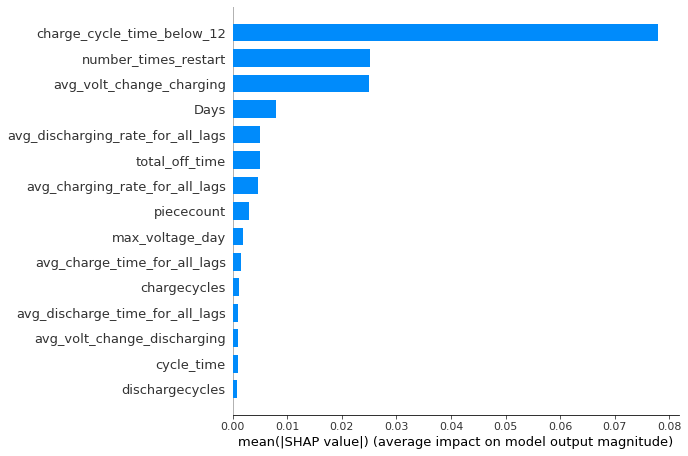

In [14]:
import xgboost
import shap 
# load JS visualization code to notebook
shap.initjs() 

# train XGBoost model
model_xg = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(x, label=y), 100)
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer_xg = shap.TreeExplainer(model_xg)
shap_values_xg = explainer_xg.shap_values(x)
shap.summary_plot(shap_values_xg, x, plot_type="bar")

#### 2) LightGBM and SHAP

[LightGBM] [Info] Number of positive: 24824, number of negative: 24934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3472
[LightGBM] [Info] Number of data points in the train set: 49758, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498895 -> initscore=-0.004421
[LightGBM] [Info] Start training from score -0.004421


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


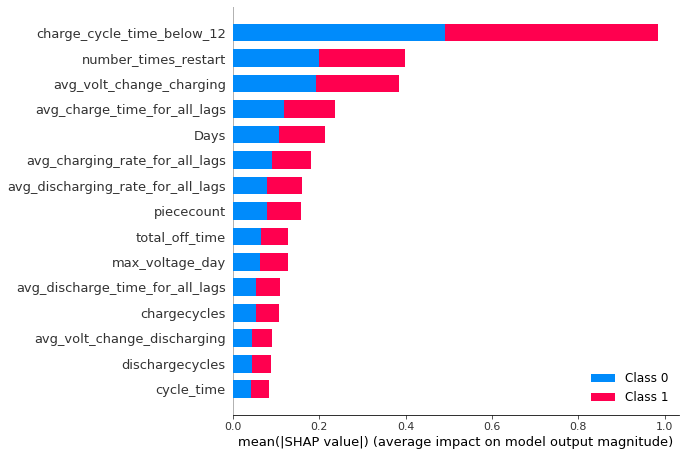

In [15]:
import lightgbm as lgb
shap.initjs()

lgb_dtrain = lgb.Dataset(data = x_train, label = y_train) 
lgb_param = {"objective": "binary", "metric": "binary_logloss"} #Binary
lgb_model = lgb.train(lgb_param, lgb_dtrain)

explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(x_test)
shap.summary_plot(shap_values_lgb, x_test, plot_type = "bar")

**Features selected:**<br/>
"charge_cycle_time_below_12", "avg_volt_change_charging", "number_times_restart","Days", "cycle_time","max_voltage_day", "piececount","total_off_time", "avg_discharging_rate_for_all_lags","avg_volt_change_discharging"
<br/>
<br/>
We select _TOP 10 features_ based on two graphs for the further analysis.

##### Model Selection 
Create a pipeline to select best model based on scores. <br/>
Since it's classification model, choose and compare 4 different classifier; _XGB, Random Forest, Gradient Boosting, Ada boost._

In [31]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (precision_score, f1_score, recall_score, accuracy_score, 
average_precision_score ,auc,roc_auc_score)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [32]:
target = smote_df["fail_7"]
# Apply Top 10 features
features = smote_df[["charge_cycle_time_below_12", 
                "avg_volt_change_charging", 
                "number_times_restart",
                "Days",
                "cycle_time",
                "max_voltage_day",
                "piececount",
                "total_off_time",
                "avg_discharging_rate_for_all_lags",
                "avg_volt_change_discharging"]]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [33]:
def training_predict(trainer, X_train, Y_train, X_test, Y_test):
    scores = {} # Initializing a Dictionary to store evaluation metrics
    
    trainer.fit(X_train, Y_train)  # Training
    Y_pred = trainer.predict(X_test) # Predicts
    
    '''
    Stores the result of trainer in its individual Key
    '''
    scores['auc'] = roc_auc_score(Y_test , trainer.predict_proba(X_test)[:,1])
    scores["AP-SCORE"]=average_precision_score(Y_test , trainer.predict_proba(X_test)[:,1])
    scores['Recall_test'] = recall_score(Y_test , Y_pred)
    scores['Precision_test'] = precision_score(Y_test , Y_pred)
    scores['F1_Score_test'] = f1_score(Y_test , Y_pred)
    
    return scores

In [34]:
xgb = XGBClassifier(random_state= 42,)
rf = RandomForestClassifier(random_state= 42,class_weight='balanced')
gbm=GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state = 42)
predictors = {} # Initializing a dictionary to store training and testing data
 
for model in [rf, gbm, xgb, ada]:
    model_name = model.__class__.__name__
    predictors[model_name]  = {}
    pipe=make_pipeline(model)
    predictors[model_name] =  training_predict(pipe, x_train, y_train, x_test, y_test) 
    #Scores that is returned from trainer goes to
    print(predictors)

{'RandomForestClassifier': {'auc': 0.8520657935457225, 'AP-SCORE': 0.8597624826760161, 'Recall_test': 0.8015071348404682, 'Precision_test': 0.7466766243465273, 'F1_Score_test': 0.7731209403031242}}
{'RandomForestClassifier': {'auc': 0.8520657935457225, 'AP-SCORE': 0.8597624826760161, 'Recall_test': 0.8015071348404682, 'Precision_test': 0.7466766243465273, 'F1_Score_test': 0.7731209403031242}, 'GradientBoostingClassifier': {'auc': 0.7170102334538897, 'AP-SCORE': 0.6916281700368943, 'Recall_test': 0.7012987012987013, 'Precision_test': 0.6457994980067917, 'F1_Score_test': 0.6724058416602614}}
{'RandomForestClassifier': {'auc': 0.8520657935457225, 'AP-SCORE': 0.8597624826760161, 'Recall_test': 0.8015071348404682, 'Precision_test': 0.7466766243465273, 'F1_Score_test': 0.7731209403031242}, 'GradientBoostingClassifier': {'auc': 0.7170102334538897, 'AP-SCORE': 0.6916281700368943, 'Recall_test': 0.7012987012987013, 'Precision_test': 0.6457994980067917, 'F1_Score_test': 0.6724058416602614}, 'XGB

In [35]:
pd.DataFrame.from_dict(predictors).T

,auc,AP-SCORE,Recall_test,Precision_test,F1_Score_test
RandomForestClassifier,0.852066,0.859762,0.801507,0.746677,0.773121
GradientBoostingClassifier,0.717010,0.691628,0.701299,0.645799,0.672406
XGBClassifier,0.772284,0.763199,0.733846,0.684155,0.708130
AdaBoostClassifier,0.698729,0.670729,0.679814,0.641646,0.660179


**Model Selected:** <br/>
_Random Forest Classifier_ is selected for the further analysis based on the scores.

##### Hyperparameter Tuning
Use _GridSerachCV_ to find the best parameters for the Randome Forest Classifier.

In [36]:
from sklearn.model_selection import GridSearchCV

n_estimators = [500, 800, 1200]
max_depth = [15, 25, 30]
min_samples_split = [10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

In [37]:
rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = hyperF, cv = 3, verbose=2, n_jobs = 4)

In [ ]:
rf_Grid.fit(train_x,train_y)

In [ ]:
rf_Grid.best_params_

It took approximately **7 hours** to run and get the result. <br/>
Due to time constraints, the result images are attached instead.

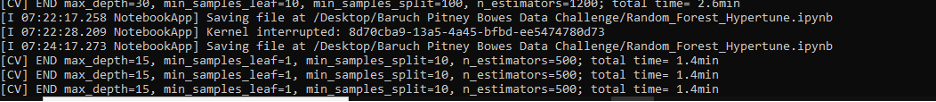

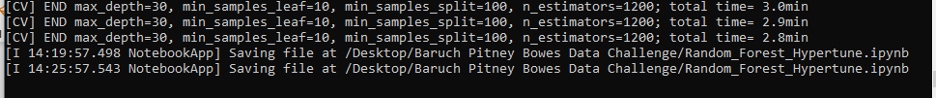

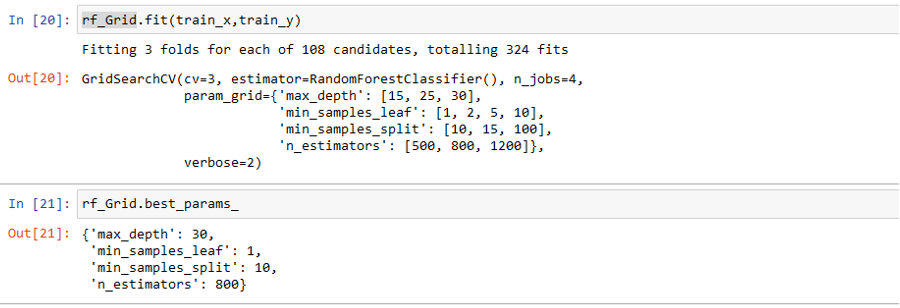